<a href="https://colab.research.google.com/github/geoochoa/ProductionTracker/blob/main/ImageClassifier_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kaggle Competition: Image Classification Project

https://www.kaggle.com/competitions/cse144-hw4-part2/overview

Geovanni Ochoa

geodochoa@gmail.com

This is an image classification in-class competition. The task is to use images of 10 different animals and train a model to classify them correctly.

In [ ]:
# Helper libraries
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import KFold
from keras.utils.np_utils import to_categorical

import numpy as np
from keras.preprocessing.image import image
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions

from keras import applications
from keras import optimizers

Provided code to open and save to a pickle file:

In [ ]:
## This opens a *.pkl file

def unpickle(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

# this saves "thing" to a *.pkl file
def to_pickle(thing, filename):
    with open(filename, "wb") as f:
        pickle.dump(thing, f)
        f.close()

Provided code for getting a feel for the dataset:

In [ ]:
train = unpickle("./train.pkl")
print("Train:")
print(train["data"].shape)
print(train["label"].shape)

print("\nTest:")
test = unpickle("./test.pkl")
print(test["data"].shape)
#print(test["label"].shape)

print(train["data"])

Train:
(10000, 12288)
(10000,)

Test:
(2000, 12288)
[[ 41  40  55 ...  43  40  43]
 [ 35  33  37 ...  90  88  96]
 [161 172 173 ...  99 105 110]
 ...
 [ 71  17  30 ... 163 179 179]
 [128 119 125 ...  77  53  45]
 [152 142 129 ...  42  47  50]]


More provided code, the label dictionary mapping correct pairs:

In [ ]:
# label dictionary: this maps label integer to the name of the animal
label2name = {1: 'dog',
              2: 'rabbit',
              3: 'deer',
              4: 'elephant',
              5: 'horse',
              6: 'squirrel',
              7: 'tiger',
              8: 'wolf',
              9: 'chimpanzee',
              10: 'panda'}

More provided code to show images from dataset:

In [ ]:
# this plots one image -- given the image index
def show_image(idx, train, label2name=label2name):
    img = train["data"][idx]
    img = np.dstack((img[:4096], img[4096:8192], img[8192:])).reshape(64,64,3)
    plt.imshow(img)
    plt.title(label2name[train["label"][idx]])
    plt.show()

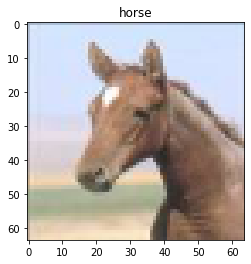

In [ ]:
show_image(2, train)

Getting the data and splitting this into training and testing set:

In [ ]:

train = unpickle("./train.pkl")
test = unpickle("./test.pkl")

trainX = train["data"]
testX = test["data"]

m = trainX.shape[0]

#Splitting the rgb channels
trainX = np.dstack((train['data'][:, :4096], train['data'][:, 4096:8192], train['data'][:, 8192:])).reshape(-1, 64,64,3)
testX2 = np.dstack((test['data'][:, :4096], test['data'][:, 4096:8192], test['data'][:, 8192:])).reshape(-1, 64,64,3)

trainX, testX = trainX[:math.floor(m*.8)], trainX[math.floor(m*.8):]
trainY, testY = train['label'][:math.floor(m*.8)] - 1, train['label'][math.floor(m*.8):] - 1

def preprocessD(X, Y):
  tX = keras.applications.resnet50.preprocess_input(X)
  tY = keras.utils.to_categorical(Y, num_classes=10)
  return tX, tY

x_train, y_train = preprocessD(trainX, trainY)
x_test, y_test = preprocessD(testX, testY)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(8000, 64, 64, 3) (8000, 10)
(2000, 64, 64, 3) (2000, 10)


Importing relevant libraries:

In [ ]:
#I opted to leave many imported libraries here as I frequently changed them
 #   during testing
  #  Most notably: SGD. I tried other optimizers but SGD went best for this
   #   architecture.

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam, Adagrad, RMSprop
from keras.models import Sequential
from matplotlib import pyplot
from numpy import mean
from numpy import std
from keras import applications
from keras import optimizers

from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

VGG16 Architecture:

In [ ]:
# This performed best for me, better than ResNet50.
input_t = keras.Input(shape = (224,224,3))
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=input_t)

for layer in base_model.layers[:143]:  
    layer.trainable = False

#for i, layer in enumerate(base_model.layers):
  #print(i, layer.name, "-", layer.trainable)

to_res = (224,224)
model = Sequential()
model.add(keras.layers.Lambda(lambda image: tf.image.resize(image, to_res)))
model.add(base_model)
model.add(Flatten())

#model.add(GlobalAveragePooling2D())

model.add(BatchNormalization())
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())
model.add(Dense(164, activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

#model = Model(inputs=base_model.input, outputs=model(base_model.output))

#Using Binary_crossentropy, I wanted to use categorical_crossentropy to make
  #use of the one hot encoding but couldn't get better results than with binary
#0.01 LR truly worked the best here, I implemented an annealer to help
#with underfitting at first but it didnt work for me
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

#history = model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(x_test, y_test))

In [ ]:

#Tried optimal batch sizes within 32-64 and 64 performed the best
batch_size = 32
epochs = 6

#Data Augmentation: Slightly augmented these images but this wasn't completely
#necessary as the data was fixed and already good. I understand from doing
#research on this HW that many datasets we get may not be so perfect so this will
#play a huge role when using those datasets.
train_datagen = ImageDataGenerator( horizontal_flip=True)
train_datagen.fit(x_train)

#Fitting the model
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,
    validation_data=(x_test, y_test)
)

Epoch 1/6
250/250 [==============================] - 64s 176ms/step - loss: 0.4391 - accuracy: 0.4810 - val_loss: 0.0772 - val_accuracy: 0.9140
Epoch 2/6
250/250 [==============================] - 41s 164ms/step - loss: 0.0690 - accuracy: 0.9118 - val_loss: 0.0400 - val_accuracy: 0.9360
Epoch 3/6
250/250 [==============================] - 42s 166ms/step - loss: 0.0334 - accuracy: 0.9501 - val_loss: 0.0332 - val_accuracy: 0.9455
Epoch 4/6
250/250 [==============================] - 41s 165ms/step - loss: 0.0211 - accuracy: 0.9699 - val_loss: 0.0304 - val_accuracy: 0.9465
Epoch 5/6
250/250 [==============================] - 41s 165ms/step - loss: 0.0131 - accuracy: 0.9851 - val_loss: 0.0295 - val_accuracy: 0.9485
Epoch 6/6
250/250 [==============================] - 41s 165ms/step - loss: 0.0075 - accuracy: 0.9945 - val_loss: 0.0292 - val_accuracy: 0.9475


Plotting the graphs:

 Train accuracy=0.99187, Validation accuracy=0.94750


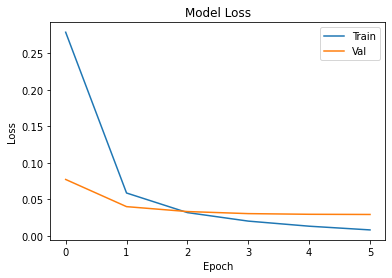

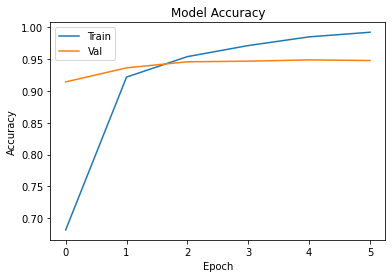

In [ ]:

print(" Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(epochs,history.history['accuracy'][epochs-1],history.history['val_accuracy'][epochs-1]))
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
  

plot_losses(history)
plot_accuracies(history) 

Transfer to csv file the predictions:

In [ ]:
Xx = np.dstack((test['data'][:, :4096], test['data'][:, 4096:8192], test['data'][:, 8192:])).reshape(-1, 64,64,3)
x_test_proc = preprocess_input(Xx)

predics = model.predict(x_test_proc)
predics1 = np.argmax(predics, axis = 1) + 1
preDF = pd.DataFrame(predics1, columns=['label'])
preDF.to_csv('./predic.csv', index=True, index_label='id')

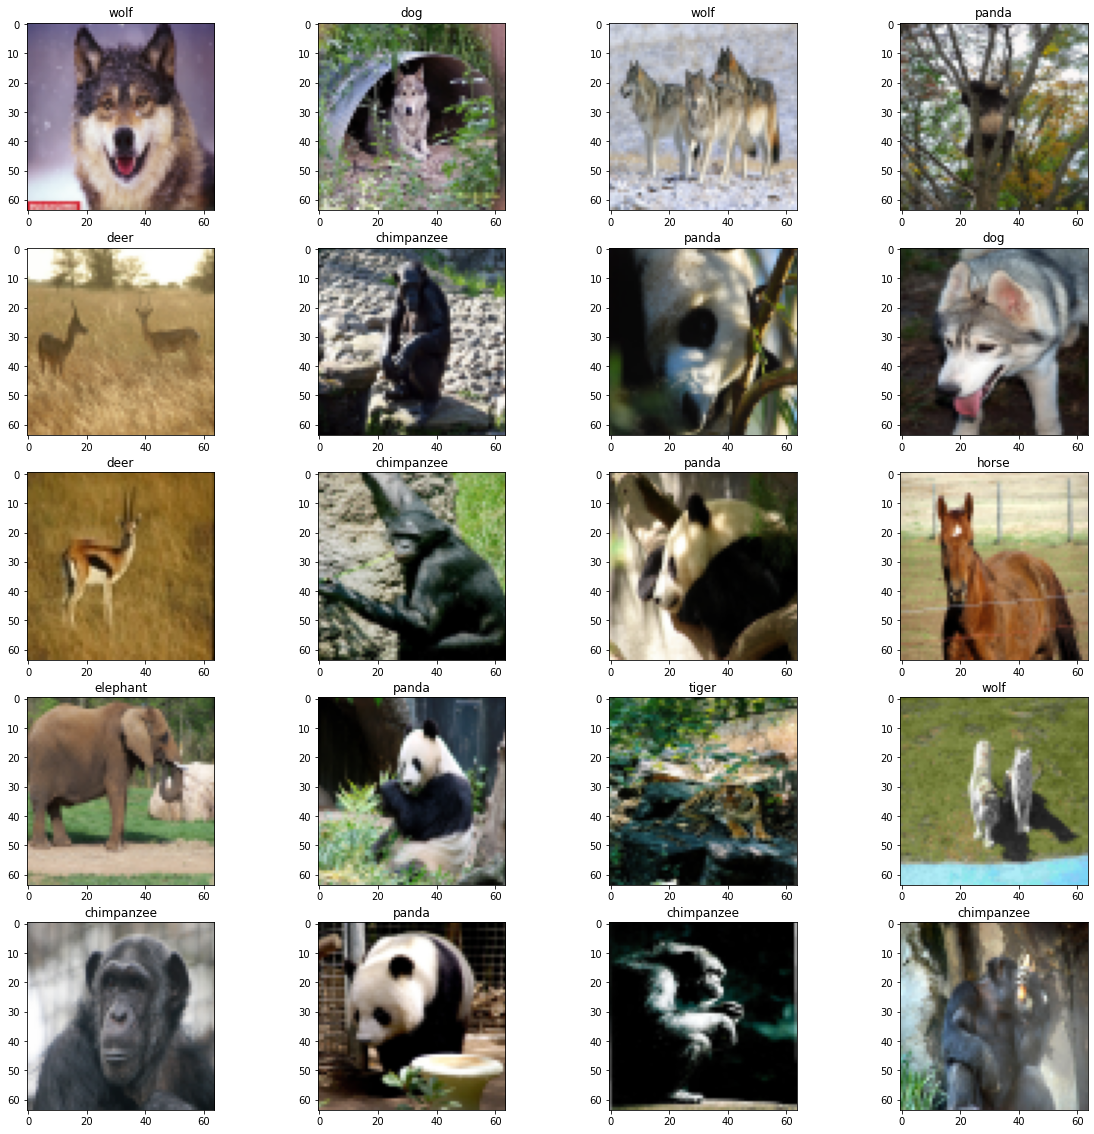

In [ ]:
m = Xx.shape[0]
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 5
for i in range(m - columns*rows, m):
    img = Xx[i]
    f = fig.add_subplot(rows, columns, i + 1 - (m - columns * rows))
    f.set_title(label2name[predics1[i]])
    plt.imshow(img)
plt.show()